# Emission AI

#### Microsoft AI for Earth Project
AI Monitoring Coal-fired Power Plant Emission from Space 
#### Team Members
Ziheng Sun, Ahmed Alnaim, Zack Chester, Daniel Tong
#### Date
4/30/2020-10/30/2021
#### Abstract
The goal is to build a reusable machine learning model to estimate the emission of coal-fired power plants by satellite observations. The machine learning model will be trained on the monitoring data of the power plants collected from EPA eGRID, and the remote sensed datasets of TROPOMI on Sentinel 5 Precursor and the meterological observations from MERRA.

The model will take remote sensing records as inputs, and output an estimated NOX emission daily volume. 


### Step 1: Read CSV

The demo CSV files are located in the folder `data`. The CSV initially contains six columns: Facility ID (EPA Code of PP), Latitude, Longitude, Date, EPA Daily NO2 divided by 1e+05, TROPOMI NO2_column_number_density (Total vertical column of NO2, ratio of the slant column density of NO2 and the total air mass factor). Both [EPA](https://www.epa.gov/egrid), [TROPOMI](http://www.tropomi.eu/) and [MERRA](https://gmao.gsfc.nasa.gov/reanalysis/MERRA/) datasets can be accessed and retrieval free of charge. 

One preprocessing step is to turn the date column into three separate columns as the machine learning cannot parse date strings as input. It need be turned into numeric values. We transform the date column into dayofweek, dayofmonth, and dayofyear. The original date column is excluded from the training dataset to pass the data type checker. 

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plotting and Visualizing data
from sklearn.model_selection import train_test_split
import os
print(os.listdir("data"))

# Describe the data, and get a overview
data = pd.read_csv('data/tropomi_epa_kvps_NO2_2019_56.csv',parse_dates=["Date"])

print("==================>")
print(data.describe())

data['dayofyear'] = data['Date'].dt.dayofyear
data['dayofweek'] = data['Date'].dt.dayofweek
data['dayofmonth'] = data['Date'].dt.day
data = data.drop(columns=["Date"])

print("==================>")
print(data.columns)

# Separating dependednt & Indepented Variables 
x = data.iloc[:, data.columns != 'EPA_NO2/100000'].values
y = data.iloc[:, data.columns == 'EPA_NO2/100000']

# show the shape of x and y to make sure they have the same length

# Train Test Split at ratio 0.33
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

y_train = y_train.ravel()
y_test = y_test.ravel()

print("===================>")
print("X_train's shape: ", x_train.shape)
print("y_train's shape: ", y_train.shape)
print("x_test's shape: ", x_test.shape)
print("y_test's shape: ", y_test.shape)

# print(y_test)
# print(y_train)


['tropomi_epa_kvps_NO2_2018_56.csv', 'tropomi_epa_kvps_NO2_2019_56.csv']
==================>
         FID      Latitude     Longitude  EPA_NO2/100000  TROPOMI*1000  \
count  167.0  1.670000e+02  1.670000e+02      167.000000    167.000000   
mean    56.0  3.148802e+01 -8.791075e+01        0.202637      0.073023   
std      0.0  1.425359e-14  8.552157e-14        0.095789      0.017048   
min     56.0  3.148802e+01 -8.791075e+01        0.000180      0.038700   
25%     56.0  3.148802e+01 -8.791075e+01        0.142335      0.061850   
50%     56.0  3.148802e+01 -8.791075e+01        0.202720      0.069900   
75%     56.0  3.148802e+01 -8.791075e+01        0.242405      0.081050   
max     56.0  3.148802e+01 -8.791075e+01        0.459370      0.127100   

       Wind (Monthly)  Temp (Monthly)  Precip (Monthly)  \
count      167.000000      167.000000        167.000000   
mean         3.871367      292.725567          0.000052   
std          0.367921        7.072844          0.000026   
min 

### Step 2: Train Deep Learning model

The hyperparameter tuning is a very troublesome task. Use Keras tensorflow model.  

In [66]:
# Model Import and Build
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam

model = keras.Sequential(
    [
        keras.Input(shape=(11)),
        layers.Dense(500, activation="relu"),
        layers.Dense(500, activation="relu"),
        layers.Dense(500, activation="relu"),
        layers.Dense(500, activation="relu"),
        layers.Dense(500, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
        
    ]
)  # No weights at this stage!

# Call the model on a test input
# x = tf.ones((1, 4))
# y = model(x)
print("Number of weights after calling the model:", len(model.weights))  # 6

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

# sgd = SGD(lr=lr_schedule)

model.summary()
model.compile(optimizer="adadelta", loss="mse",  metrics=[tf.keras.metrics.mean_squared_error])

model.fit(x_train, y_train, batch_size=16, validation_split = 0.15, epochs=100)

Number of weights after calling the model: 12
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 500)               6000      
_________________________________________________________________
dense_177 (Dense)            (None, 500)               250500    
_________________________________________________________________
dense_178 (Dense)            (None, 500)               250500    
_________________________________________________________________
dense_179 (Dense)            (None, 500)               250500    
_________________________________________________________________
dense_180 (Dense)            (None, 500)               250500    
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 501       
Total params: 1,008,501
Trainable params: 1,008,501
Non-trainable params:

Epoch 45/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 46/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 47/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 48/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 49/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 50/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 51/100
6/6 [======================

### Step 3: Test ML model

Predict on the test dataset using the trained models

In [67]:
# Use the trained models to make predictions
y_test_pred = model.predict(x_test)

### Step 4: Visualize the Results

Visualization of the ML results could facilitate the intercomparison of machine learning models and identify the pros and cons of various models in different groups of data samples.  

Blue dots are the true observation of EPA. Black dots are the predicted values of machine learning models. 

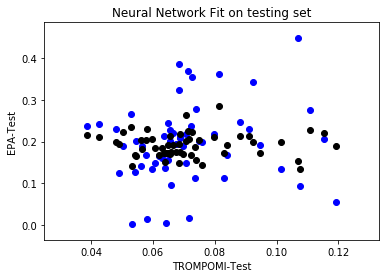

In [68]:
def visualizeResults(modelname, x_test, y_test, pred):
    # Visualization
    ## Check the fitting on training set
    plt.scatter(x_test[:,3], y_test, color='blue')
    plt.scatter(x_test[:,3], pred, color='black')
#     plt.scatter(y_test, pred, color='black')
    plt.title(modelname + ' Fit on testing set')
    plt.xlabel('TROMPOMI-Test')
    plt.ylabel('EPA-Test')
    plt.show()
    
visualizeResults("Neural Network", x_test, y_test, y_test_pred)

### Step 5: Calculate quantitative metrics

For a regression task, the accuracy metrics are normally mean squared error (MSE), mean absolute error (MAE), and coefficient of determination (R2). 

In [44]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

def showAccuracyMetrics(mlmethod, model, y_test, y_pred):
    print("Model ", mlmethod, " Performance:")
#     print(y_test.shape, y_pred.shape)
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    print("   MAE: ", mae)
    print("   MSE: ", mse)
    print("   R2: ", r2)
    
# print(y_test, linear_pred)

showAccuracyMetrics("Neural Network: ", model, y_test, y_test_pred)

Model  Neural Network:   Performance:
   MAE:  0.07036026528682027
   MSE:  0.009494947684429626
   R2:  -0.09887729192323125


### Step 6: Feature Importance

0 - 'FID', 

1 - 'Latitude', 

2 - 'Longitude', 

3 - 'TROPOMI*1000',

4 - 'Wind (Monthly)', 

5 - 'Temp (Monthly)', 

6 - 'Precip (Monthly)',

7 - 'Cloud Fraction (Monthly)', 

8 - 'dayofyear', 

9 - 'dayofweek', 

10 - 'dayofmonth'

In [72]:
def showImportance(model):
    labels = ['FID', 'Latitude', 'Longitude', 'TROPOMI*1000',\
       'Wind (Monthly)', 'Temp (Monthly)', 'Precip (Monthly)',\
       'Cloud Fraction (Monthly)', 'dayofyear', 'dayofweek', 'dayofmonth']
    # get importance
    importance = model.best_estimator_.feature_importances_
    print(len(labels))
    print(importance)
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (labels[i],v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
# showImportance(rf_regressor)

### Conclusion

This notebook shows how to use machine learning models to predict the emission of coal-fired power plants using satellite observations like TROPOMI and meteorology observations from MERRA. 

The results show that random forest and voting ensemble models are similar in the performance. The random forest model has a slightly better performance in this case. That is also because the ensembled model is from the trained linear regression and the random forest models. The results are basically an average between the two models' results.  

Linear regression model outputs basically the values in a narrow range regarless of the variances in the TROPOMI observation and never produce the values greater than 0.3 or less than 0.1. It is not suitable for this prediction. 

##### Final Remarks

Using machine learning to predict ground emission from remote sensed data is possible. More improvements are needed to ensure the accuracy, generality, and stability of the trained models in a long-term operational run. The demonstrated power plant site is in the rural area in Alabama and there is less NO2 emission sources other than the power plant itself. More research is required to make it work for those power plants located in or nearby urban regions, where other emission sources may dominate the NOX in the atmosphere. 


### Citation

Please cite this work as: 
    
`Sun, Ziheng, Zack Chester, and Daniel Tong. 2021. "EmissionAI: Ai Monitoring Coal-Fired Power Plant Emission from Space."  https://github.com/ZihengSun/EmissionAI  `